<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/Practica7.3.%20Transferencia%20Estilo%20Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow import keras
print(keras.__version__)
# veamos la GPU asignada
!nvidia-smi --query-gpu=gpu_name --format=csv

2.4.0
name
Tesla T4


# Práctica 7.3. Neural style transfer


Además de Deep Dream, otro importante desarrollo en modificación de imágenes es la trasferencia de estilo, desarrollado por Leon Gatys y otros autores durante el verano de 2015.

Existen muchas variantes del algoritmo de transferencia de estilo basados en el original que se han ido adaptando y mejorando. Algunos de ellos incluso se han adaptado para ser usado en aplicaciones móviles. Por simplicidad nos centraremos en el algoritmo descrito en el artículo original.

La transferencia de estilo consiste en aplicar el estilo, usualmente pictórico, de una imagen de referencia a otra imagen, normalmente una fotografía:

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

Lo que nosotros entenderemos por "estilo" es esencialmente las texturas, colores y los patrones visuales de la imagen en varias escalas espaciales. Por otro lado, entenderemos por "contenido" a la macroestructura de la imagen. Por ejemplo, en la imagen anterior los trazos circulares azules y amarillos son considerados estilos, mientras que los edificios de la fotografía son considerados "contenido".

La idea detrás de la transferencia de estilo está muy relacionada con la generación de texturas que ha sido muy estudiada en el procesamiento de imágenes. Sin embargo los resultados obtenidos con técnicas de deep learning mejoran enórmemente los obtenidos previamente con las técnicas clásicas de procesamiento de imágenes.

La noción clave detrás de esta técnica es la misma que la hemos visto en varias aplicaciones anteriormente: definir una función de coste que especifique que queremos alcanzar a través de la minimización. En este caso lo que queremos alcanzar es la conservación del "contenido" de la imagen original mientras se adopta el "estilo" de la imagen de referencia. Si somos capaces de definir matemáticamente qué es el contenido y qué es el estilo entonces podremos definir esta función de coste como:

$$
loss = distancia(estilo(imagen\_de\_ref) - estilo(imagen\_gen)) +
       distancia(contenido(imagen\_orig) - contenido(imagen\_gen))
$$


Donde la "distancia" será la norma L2, $contenido$ una función que dada una imagen extrae su "contenido" y $estilo$ es una función que dada una imagen extrae su "estilo"

Minimizando esta función de coste conseguiremos que $estilo(imagen\_gen)$ se aproxime a $estilo(imagen\_ref)$ y que $contenido(imagen\_gen)$ se aproxime a $contenido(imagen\_gen)$.

Una observación fundamental realizada por Gatus et al. fue que la redes convolucionales ofrecen precisamente un forma para definir matemáticamente el "estilo" y el "contenido".

## 1. El coste del contenido

Como ya sabemos, la activaciones de las primeras capas en una red detectan información muy *local* sobre la imagen, mientras que las activaciones más profundas representan la información más *global* y *abstracta*. Dicho de otra forma, las activaciones de la red proporcionan una descomposición del contenido de la imagen a diferentes escalas. Por tanto, se espera que el *contenido* de la imagen, el cual es más global y abstracto, sea capturado por la representaciones de las últimas capas.

Un buen candidato para una función pérdida del *contenido* sería entonces considerar un convnet pre-entrenada, y definir como nuestra pérdida la norma L2 entre las activaciones de una capa superior calculada sobre la imagen objetivo y las activaciones de la misma capa calculadas sobre la imagen generada. Esto garantizaría que, tal y como se ve desde la capa superior de la red convolucional, la imagen generada "se verá similar" a la imagen de destino original. Asumiendo que lo que ven las capas superiores de una red convolucional es realmente el "contenido" de sus imágenes de entrada, entonces esto funciona como una forma de preservar el contenido de la imagen.

## 2. El coste del estilo

Mientras que para el contenido solo se usa una capa superior, la parte de la función de coste destinada al estilo usa varias capas de la red según establece Gatys et al en el artículo original: se pretende extraer el estilo en todas las escalas no únicamente en una de ellas.

Para el cálculo de esta parte del coste, Gatys usa una matriz de Gram sobre las activaciones de las capas, por ejemplo el producto *interior* entre los mapas de características de una capa. Este producto *interior* se puede ver como una representación de las correlaciones entre la caracterísicas de una capa. Esas correlaciones capturan los patrones estadísticos de una escala en particular, lo cual corresponde empíricamente a la apariencia de las texturas encontradas en esa escala.

Por lo tanto, la pérdida de estilo tiene como objetivo preservar correlaciones internas similares dentro de las activaciones de las diferentes capas, a través de la imagen de referencia del estilo y de la imagen generada. A su vez, esto garantiza que las texturas encontradas a diferentes escalas espaciales se vean similares a través de la imagen de referencia de estilo y la imagen generada.

## 3. En resumen

Usaremos una red convolucional pre-entrenada  para definir una función de coste en la que:

* Preservaremos el contenido manteniendo *activaciones* de capa similares de alto nivel entre la imagen de contenido de destino y la imagen generada. La red debe "ver" tanto la imagen de destino como la imagen generada como "que contiene las mismas cosas".
* Preservaremos el estilo manteniendo *correlaciones* similares dentro de las activaciones tanto para las capas de bajo nivel como para las de alto nivel. De hecho, las correlaciones de las características capturan las texturas: la imagen de referencia generada y el estilo deben compartir las mismas texturas a diferentes escalas espaciales.

Veremos que la implementación del artículo original en Keras contiene partes muy similares a las usadas en el ejemplo de Deep Dream.

## 4. Neural style transfer en Keras

Podemos usar cualquier red pre-entrenada. En este ejemplo usaremos la VGG19, usada por Gatys. 

Haremos lo siguiente:

* Configuraremos la red para extraer las activaciones de las capas seleccionadas de la imagen generada y la de referencia.
* Usaremos las activaciones para calcular la función de coste definida, la cual vamos a minimizar.
* Usaremos el proceso del gradiente descendente para minimizar la función coste.

Vamos a empezar definiendo las rutas de la imágenes a usar asegurando que ambas tiene un tamaño similar. Más adelante las redimensionaremos a 400px de alto.


In [10]:
from keras.preprocessing.image import load_img, img_to_array

# Puedes descargar imágenes desde la web con Keras
#target_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
#style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")

# O bien ponerlas en una carpeta al lado de este notebook
target_image_path = 'img/giralda.jpg'
style_reference_image_path = 'img/modernism.jpg'

result_prefix = "giralda_generated"

# Dimensiones de la imagen
width, height = load_img(target_image_path).size

# Calculamos el ancho y redimensionamos a 400px de alto
img_height = 400
img_width = int(width * img_height / height)

Veamos las dos imágenes que vamos a mezclar:

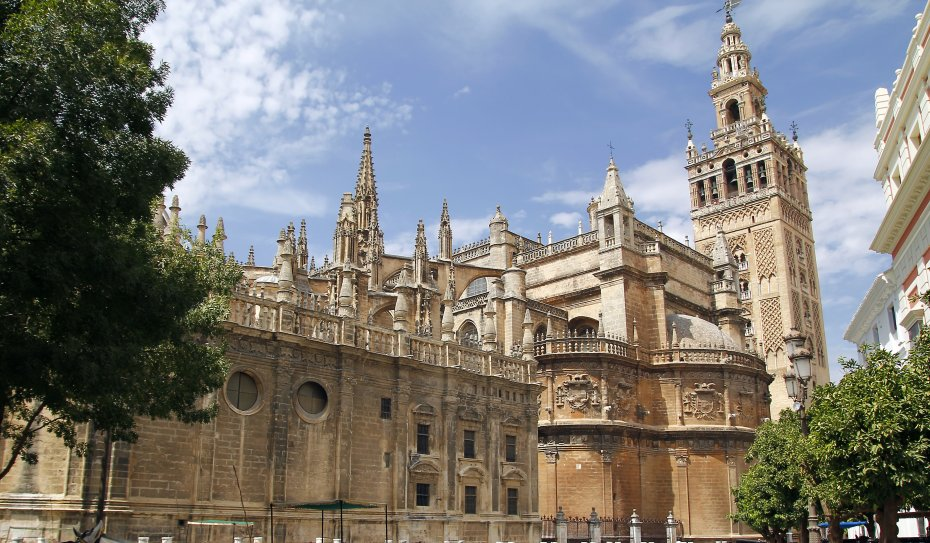

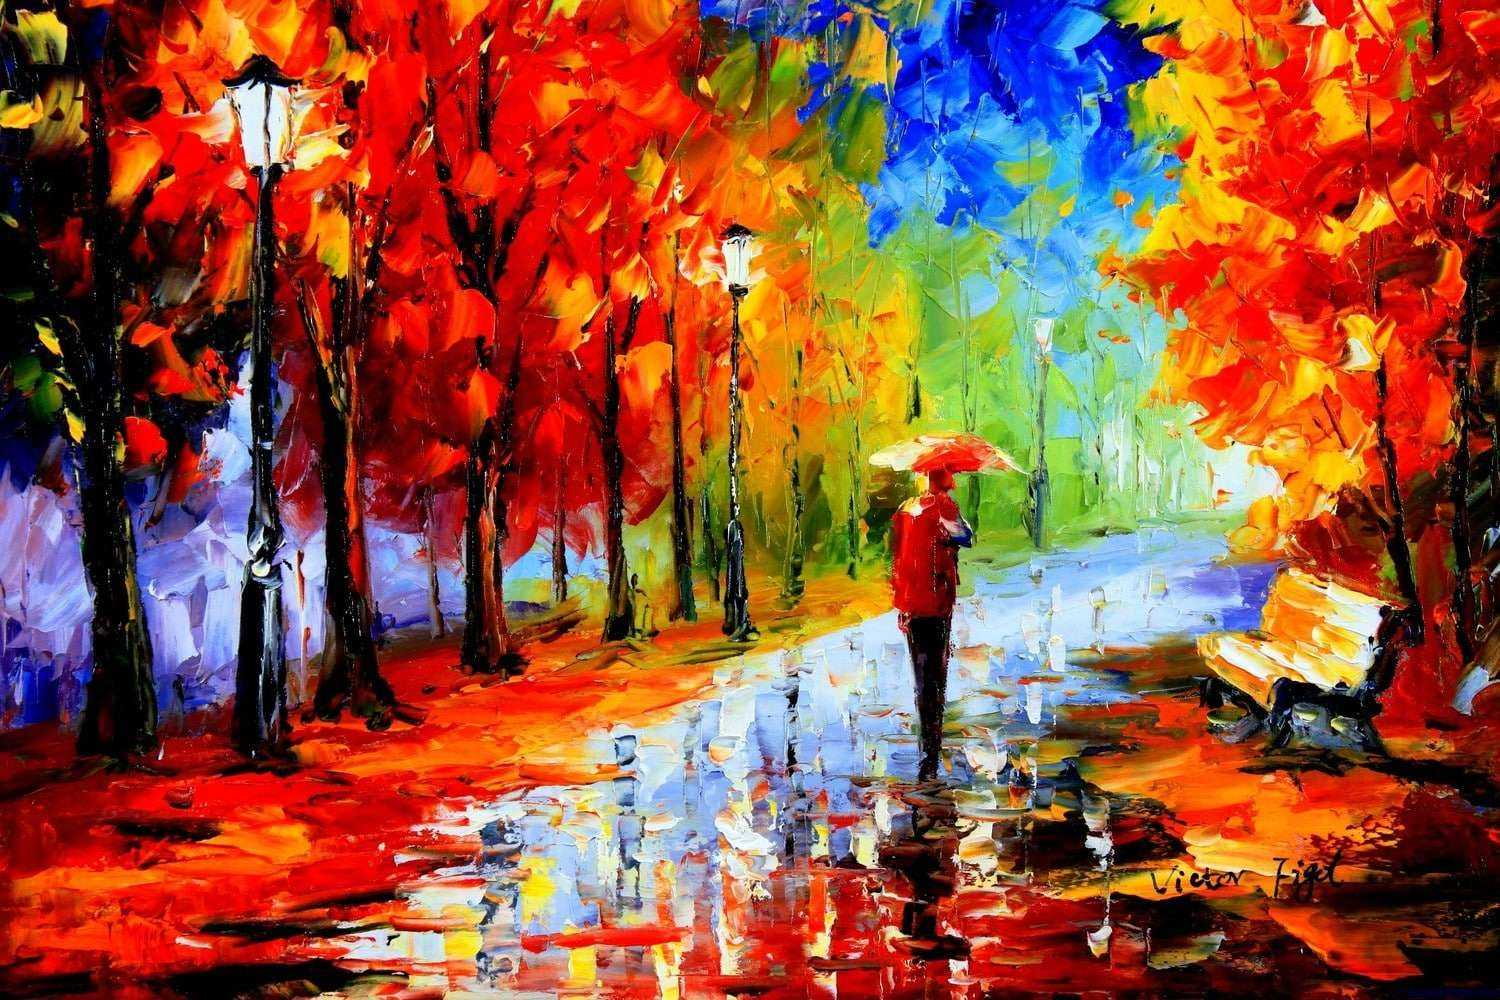

In [11]:
from IPython.display import Image, display

display(Image(target_image_path))
display(Image(style_reference_image_path))

### Funciones auxiliares

Necesitaremos un par de funciones auxiliares para preprocesar y post-procesar las imagenes que daremos y que obtendremos de la VGG19:

In [12]:
import numpy as np
from keras.applications import vgg19

# Función para abrir, redimensionar y formatear imágenes
# en tensores apropiados
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

# Función para convertir un tensor en una imagen válida
def deprocess_image(x):
    x = x.reshape((img_height, img_width, 3))
    # Eliminar el cero centro por píxel medio
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Función de coste

Primero, definimos 3 funciones auxiliares:

* `gram_matrix` (usado para calcular la pérdida del estilo (style loss))
* La función `style_loss`, que manteine a la imagen generada cerca de las texturas locales de la imagen de referencia.
* La función `content_loss`, que mantiene la representación de alto nivel de la imagen generada cerca de la imagen base (objetivo).
* La función `total_variation_loss` que realiza una pérdida de regularización para mantener a la imagen generada con coherencia local.

Le pasaremos a la red un bloque de 3 imágenes. La imagen de referencia de estilo, la de contenido y un contenedor donde se generará la nueva imagen. Para definir este contenedor en Keras usaremos un *placeholder*, que es simplemente un tensor simbólico (como ya vimos en el módulo 3 con tensorflow). 

La imagen de referencia y la de contenido son estáticas por lo que las definimos con *K.constant*, mientras que los valores del placeholder deberán ir cambiando en cada paso de la optimización con el gradiente descendente.

In [13]:
target_image = tf.constant(preprocess_image(target_image_path))
style_reference_image = tf.constant(preprocess_image(style_reference_image_path))

# Contenedor de la imagen a generar
combination_image = tf.zeros(shape=(1, img_height, img_width, 3),dtype="float32")

# Combinamos las 3 imágenes un solo batch
input_tensor = tf.concat([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# Cargamos la red VGG19
model = vgg19.VGG19(weights='imagenet',
                    include_top=False)

# Obtenemos las salidas simbólicas para cada capa de la red en un diccionario
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Configuramos un modelo que retorna los valores de activación de cada capa
# de VGG19 (como un diccionario)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)
print('Modelo preparado.')

80142336/80134624 [==============================] - 1s 0us/step
Modelo preparado.


Definimos la función de coste de contenido:

In [14]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

Definimos una función auxiliar para calcular la matriz de Gram de una matriz de entrada:

In [15]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

Ahora podemos definir la función de coste de estilo:

In [16]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

Además de las componentes de estilo y contenido vamos a añadir una componente adicional para evitar un exceso de pixelado. Para ello establecemos que debe existir continuidad entre cada pixel y su vecino de la derecha y con el de abajo.

In [17]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


La función de coste final será una media ponderada de los costes anteriores. 

Dependiendo del estilo de la imagen de referencia y de la imagen de contenido que estés utilizando, es probable que desees ajustar el coeficiente `content_weight`, la contribución de la pérdida de contenido a la pérdida total. Un `content_weight` más alto significa que el contenido de destino será más reconocible en la imagen generada.

In [21]:
# Capa de contenido
content_layer_name = 'block5_conv2'

# Capas de estilo
style_layer_names = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1']

# Pesos de cada componente de la función de coste
total_variation_weight = 1e-6 #1e-4
style_weight = 1e-6 #1.
content_weight = 2.5e-8 #0.025

# Definimos la función de coste final
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Inicializamos el coste a cero
    loss = tf.zeros(shape=())

    # Añadimos el coste de contenido
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Añadimos el coste de estilo
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Añadimos el coste total de variación
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

### Descenso del gradiente

Por último, configuramos el gradiente descendente. En el artículo original se usaba el algoritmo L-BFG. Dado que ya lo tenemos implementado en scipy lo usaremos también aunque tiene un par de inconvenientes:

* Es necesario pasarle el valor de la función de coste y el valor de gradientes en dos funciones por separado.
* Solo puede ser aplicada a vectores de 1D (nosotros tenemos un vector de imágenes 2D).

La clase `Evaluator` calculará ambos a la vez por eficiencia:

In [19]:
# Función para obtener los valores de la pérdida actual y de los gradientes actuales.
@tf.function   # El decorador nos ayuda a que la función se compile y sea más rápida
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    # Obtener los gradientes de la imagen generada con respecto la pérdida
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Y finalmente, ejecutamos el proceso de descenso del gradiente. Vamos a usar un optimizador sencillo como el SGD, y vamos a decaer el learning rate por 0,96 cada 100 pasos. También guardaremos la imagen generada cada 100 iteraciones.

La entrada del modelo es inicialmente la concatenación de la imagen base, la de estilo y la imagen donde se guardará el resultado.

In [22]:
# Instanciamos el optimizador con un decaemiento del learning rate
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, 
                                                decay_steps=100, 
                                                decay_rate=0.96)  )

# Cargamos la entrada: objetivo + estilo + resultado
base_image = preprocess_image(target_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(target_image_path))

# Número de iteraciones del descenso del gradiente
iterations = 4000
for i in range(1, iterations + 1):
    # Llamamos a nuestra función que calcula la pérdida y el gradiente
    loss, grads = compute_loss_and_grads(combination_image, 
                                         base_image, 
                                         style_reference_image)
    # Llamamos al optimizador que hemos instanciado (solo un paso)
    optimizer.apply_gradients([(grads, combination_image)])
    # Cada 100 pasos, guardamos el resultado
    if i % 100 == 0:
        print("Iteración %d: pérdida=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_iteracion_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteración 100: pérdida=9838.88
Iteración 200: pérdida=7059.31
Iteración 300: pérdida=6110.75
Iteración 400: pérdida=5553.52
Iteración 500: pérdida=5178.08
Iteración 600: pérdida=4903.28
Iteración 700: pérdida=4690.12
Iteración 800: pérdida=4519.77
Iteración 900: pérdida=4380.12
Iteración 1000: pérdida=4263.33
Iteración 1100: pérdida=4164.19
Iteración 1200: pérdida=4078.77
Iteración 1300: pérdida=4004.31
Iteración 1400: pérdida=3938.69
Iteración 1500: pérdida=3880.37
Iteración 1600: pérdida=3828.25
Iteración 1700: pérdida=3781.36
Iteración 1800: pérdida=3738.90
Iteración 1900: pérdida=3700.34
Iteración 2000: pérdida=3665.20
Iteración 2100: pérdida=3633.01
Iteración 2200: pérdida=3603.38
Iteración 2300: pérdida=3576.09
Iteración 2400: pérdida=3550.86
Iteración 2500: pérdida=3527.48
Iteración 2600: pérdida=3505.77
Iteración 2700: pérdida=3485.60
Iteración 2800: pérdida=3466.78
Iteración 2900: pérdida=3449.19
Iteración 3000: pérdida=3432.73
Iteración 3100: pérdida=3417.31
Iteración 3200: p

Miremos el resultado. Bonito, ¿verdad? Juega con los parámetros y con imágenes distintas

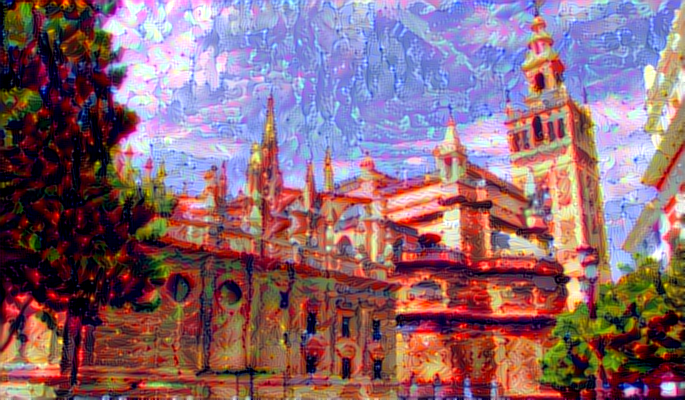

In [25]:
display(Image(result_prefix + "_iteracion_4000.png"))